In [1]:
import os.path
import json
from glob import glob
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns

plt.style.use(['fivethirtyeight'])
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 400)
pd.set_option('display.max_colwidth', 100)

colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]
ops = ['put', 'get', 'delete']

In [2]:
specs = pd.read_json(os.path.expanduser('~/PycharmProjects/benchmarking_test/results/lsm_part' + 
                                        '/benchmark_part_lsm_specs.jsonl'), lines=True)
print(len(specs))
specs.head()

105


,spec,created_at,events,id,last_modified,status
0,"{'partitions': 8, 'seconds': 3600, 'value_length': 1024, 'key_space_size': 100000000, 'known_key...",2020-04-30 08:59:00.321243,"[{'msg': 'Cancelled as duplicate', 'hostname': 'master', 'time': '2020-04-30T09:35:57.903595'}]",d4712913-8ac0-11ea-b1d1-00155d010301,2020-04-30T09:35:57.903595,cancelled
1,"{'partitions': 4, 'seconds': 3600, 'value_length': 1024, 'key_space_size': 100000000, 'known_key...",2020-04-29 20:48:46.571357,"[{'msg': 'starting', 'hostname': 'ec2-35-164-210-77.us-west-2.compute.amazonaws.com', 'time': '2...",58db5279-8a7c-11ea-b1d1-00155d010301,2020-04-30T01:53:17.412197,succeeded
2,"{'partitions': 8, 'seconds': 3600, 'value_length': 1024, 'key_space_size': 100000000, 'known_key...",2020-04-30 08:59:00.805861,"[{'msg': 'Cancelled as duplicate', 'hostname': 'master', 'time': '2020-04-30T09:35:57.990984'}]",d4712919-8ac0-11ea-b1d1-00155d010301,2020-04-30T09:35:57.990984,cancelled
3,"{'partitions': 4, 'seconds': 3600, 'value_length': 1024, 'key_space_size': 100000000, 'known_key...",2020-04-30 09:38:35.072395,"[{'msg': 'starting', 'hostname': 'ec2-54-202-73-17.us-west-2.compute.amazonaws.com', 'time': '20...",5ca56830-8ac6-11ea-b1d1-00155d010301,2020-04-30T11:44:22.316646,succeeded
4,"{'partitions': 8, 'seconds': 3600, 'value_length': 1024, 'key_space_size': 100000000, 'known_key...",2020-04-29 20:48:46.144531,"[{'msg': 'starting', 'hostname': 'ec2-54-185-79-69.us-west-2.compute.amazonaws.com', 'time': '20...",58db5274-8a7c-11ea-b1d1-00155d010301,2020-04-30T01:53:23.852221,succeeded


In [3]:
specs['status'].value_counts()

succeeded    60
cancelled    45
Name: status, dtype: int64

In [4]:
results = pd.read_json(os.path.expanduser('~/PycharmProjects/benchmarking_test/results/lsm_part' + 
                                          '/benchmark_part_lsm_results.jsonl'), lines=True, convert_dates=False)
print(len(results))
results.sample(5)

23376


,delete,get_found,spec_id,delete_found,get,file_size,put,nano_time
7854,419480,24150,5ca56837-8ac6-11ea-b1d1-00155d010301,419480,93520,82957046120,420174,8388040532241
20476,26675,11093,5aa705be-8ac6-11ea-b1d1-00155d010301,26675,26401,82173600688,475954,5822339571141
6241,100587,28834,58db527d-8a7c-11ea-b1d1-00155d010301,100587,103335,87430062064,99441,6357846071399
3429,440001,25449,5ca56833-8ac6-11ea-b1d1-00155d010301,440001,98116,83145877062,441840,9296203412153
4643,43333,105168,5b6b2909-8ac6-11ea-b1d1-00155d010301,43333,732901,28280390769,86398,3419571822656


In [5]:
constant_parameters = ['seconds', 'value_length', 'key_space_size', 'known_key_rate_percent', 'trial_index',
                       'pending_write_merge_threshold', 'index_rate']

In [6]:
spec_values = pd.concat([specs[['id', 'status']], pd.DataFrame(list(specs['spec']), index=specs.index)], axis=1)
spec_values['workload'] = spec_values['put_del_get']
spec_values['index_rate'] = spec_values['base_index_rate']
spec_values = spec_values.drop(['put_del_get', 'base_index_rate'], axis=1)
for param in constant_parameters:
    assert spec_values[param].nunique() == 1, f'{param} is not constant'
spec_values = spec_values.drop(constant_parameters, axis=1)
spec_values.sample(5)

,id,status,partitions,thread_count,workload
101,5b6b290a-8ac6-11ea-b1d1-00155d010301,succeeded,4,8,GET_HEAVY
97,5b6b2904-8ac6-11ea-b1d1-00155d010301,succeeded,4,1,GET_HEAVY
93,5b6b2912-8ac6-11ea-b1d1-00155d010301,succeeded,1,1,DELETE_HEAVY
17,5b6b2909-8ac6-11ea-b1d1-00155d010301,succeeded,1,8,GET_HEAVY
89,5b6b2915-8ac6-11ea-b1d1-00155d010301,succeeded,1,4,DELETE_HEAVY


In [7]:
grouped_results = []
for spec_id, spec_results in results.groupby('spec_id'):
    spec_results = spec_results.sort_values('nano_time')
    spec_results['t'] = (spec_results['nano_time'] - spec_results['nano_time'].iloc[0]) / 1e9
    grouped_results.append({
        'spec_id': spec_id,
        'results': spec_results,
        'final_file_size': spec_results['file_size'].iloc[-1],
        'sum_put': spec_results['put'].sum(),
        'sum_get': spec_results['get'].sum(),
        'sum_delete': spec_results['delete'].sum()
    })
grouped_results = pd.DataFrame(grouped_results)
grouped_results = pd.concat([spec_values.set_index('id'), grouped_results.set_index('spec_id')], axis=1)
grouped_results = grouped_results.dropna()
grouped_results = grouped_results[grouped_results['status'].isin(['succeeded', 'running'])]
grouped_results.sample(5).T

,5b6b290a-8ac6-11ea-b1d1-00155d010301,5985707d-8a7c-11ea-b1d1-00155d010301,5aa705ba-8ac6-11ea-b1d1-00155d010301,5b6b2905-8ac6-11ea-b1d1-00155d010301,5985707c-8a7c-11ea-b1d1-00155d010301
status,succeeded,succeeded,succeeded,succeeded,succeeded
partitions,4,8,4,8,4
thread_count,8,32,4,1,32
workload,GET_HEAVY,BALANCED,PUT_HEAVY,GET_HEAVY,BALANCED
results,delete get_found spec_id delete_found get file_si...,delete get_found spec_id delete_found get file_...,delete get_found spec_id delete_found get file_siz...,delete get_found spec_id delete_found get file_siz...,delete get_found spec_id delete_found get file_...
final_file_size,6.42061e+10,6.08482e+10,1.06787e+11,1.834e+10,8.32714e+10
sum_put,5.79152e+07,1.50068e+08,1.68656e+08,2.24637e+07,1.18985e+08
sum_get,4.92276e+08,1.54608e+08,9.36948e+06,1.91052e+08,1.22573e+08
sum_delete,2.89498e+07,1.50052e+08,9.37124e+06,1.1238e+07,1.18963e+08


In [8]:
grouped_results['status'].value_counts()

succeeded    60
Name: status, dtype: int64

In [9]:
thread_to_color = dict(zip(sorted(set(spec_values['thread_count'])), colors))
partition_to_ls = dict(zip(sorted(set(spec_values['partitions'])), ['-', '--', ':']))

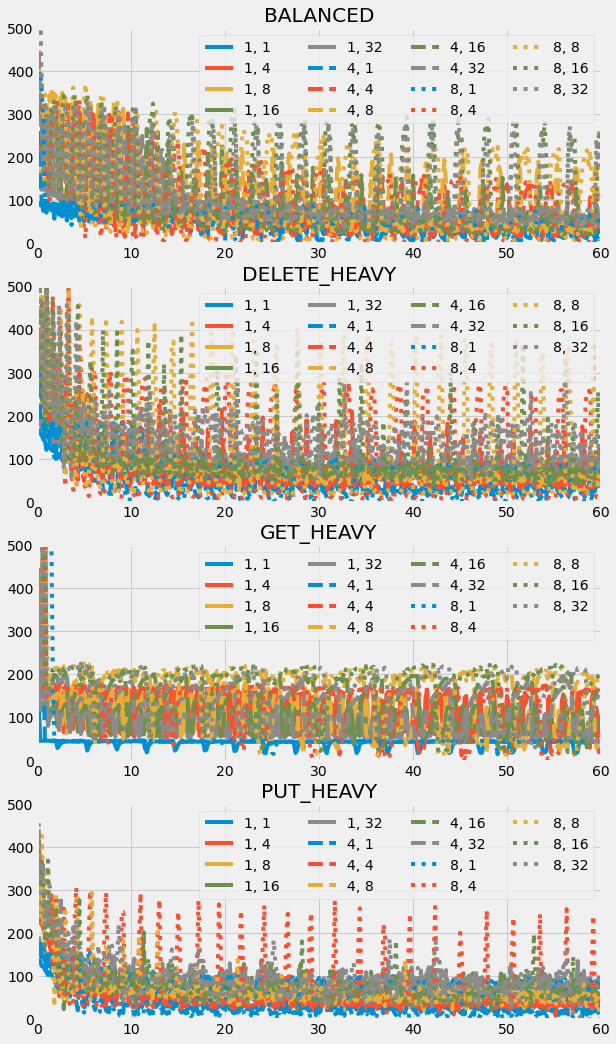

In [10]:
def diff(x):
    return x.iloc[1::].reset_index(drop=True) - x.iloc[:-1:].reset_index(drop=True)


fig = plt.figure(figsize=(9, 17))
for i, (workload, workload_df) in enumerate(grouped_results.groupby('workload')):
    ax = fig.add_subplot(4, 1, i+1)
    #print(workload, len(workload_df))
    
    for spec_id, spec_row in workload_df.sort_values(['partitions', 'thread_count']).iterrows():
        #print(workload, f"{spec_row['partitions']}, {spec_row['thread_count']}")
        row_results = spec_row['results']
        t = row_results['t'] / 60
        ops_sec = (row_results[['put', 'get', 'delete']].sum(axis=1).iloc[1::].reset_index(drop=True) /
                   diff(row_results['t']))
        ops_sec /= 1000
        ax.plot(t.iloc[1::], ops_sec,
                label=f"{spec_row['partitions']}, {spec_row['thread_count']}",
                color=thread_to_color[spec_row['thread_count']],
                ls=partition_to_ls[spec_row['partitions']])
    ax.legend(loc='upper right', ncol=4)
    ax.set_title(workload)
    plt.ylim(0, 500)
    plt.xlim(0, 60)
#plt.xlim(0, 5)

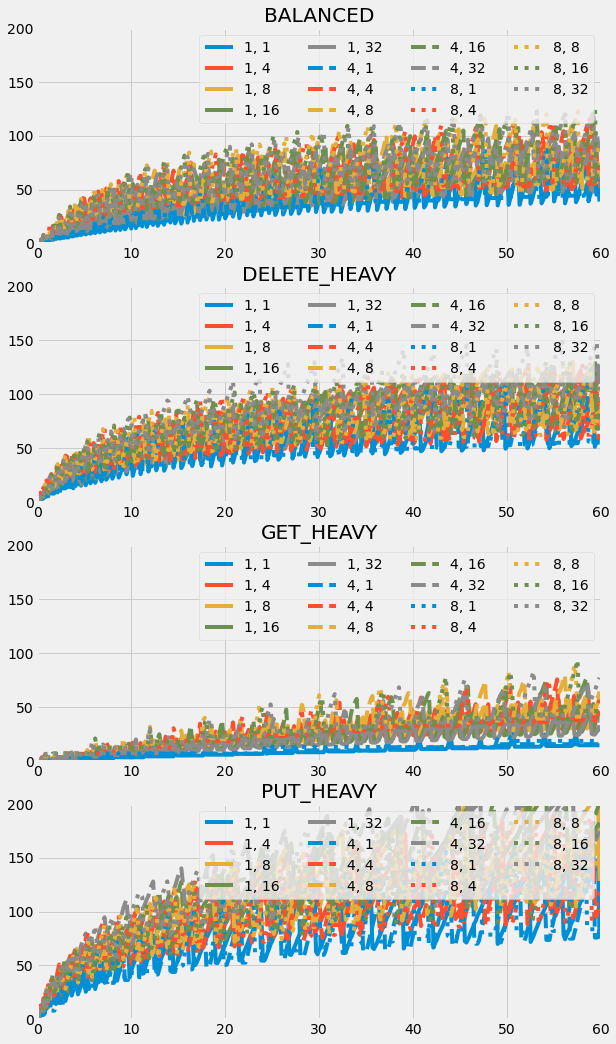

In [11]:
fig = plt.figure(figsize=(9, 17))
for i, (workload, workload_df) in enumerate(grouped_results.groupby('workload')):
    ax = fig.add_subplot(4, 1, i+1)    
    for spec_id, spec_row in workload_df.sort_values(['partitions', 'thread_count']).iterrows():
        row_results = spec_row['results']
        ax.plot(row_results['t'] / 60, row_results['file_size'] / 1e9,
                label=f"{spec_row['partitions']}, {spec_row['thread_count']}",
                color=thread_to_color[spec_row['thread_count']],
                ls=partition_to_ls[spec_row['partitions']])
    ax.legend(loc='upper right', ncol=4)
    ax.set_title(workload)
    plt.ylim(0, 200)
    plt.xlim(0, 60)


In [12]:
normed_results = grouped_results.copy()
normed_results['duration_seconds'] = normed_results['results'].map(lambda r: r['t'].max())
for op in ops:
    normed_results[op] = normed_results['sum_' + op] / normed_results['duration_seconds'] / 1000
normed_results = normed_results.drop(['results'] + ['sum_' + op for op in ops], axis=1)
normed_results['sum'] = normed_results[ops].sum(axis=1)
normed_results['final_file_size'] /= 1e9
normed_results = normed_results.set_index(['workload', 'partitions', 'thread_count'])
normed_results.sample(5)

,,,status,final_file_size,duration_seconds,put,get,delete,sum
workload,partitions,thread_count,,,,,,,
DELETE_HEAVY,1,8,succeeded,105.929045,3590.957497,37.270570,8.280731,37.272956,82.824257
GET_HEAVY,1,16,succeeded,31.681776,3590.607203,9.085283,77.230135,4.543394,90.858812
DELETE_HEAVY,1,4,succeeded,94.265181,3591.190748,34.836795,7.741864,34.836346,77.415004
GET_HEAVY,1,1,succeeded,14.282154,3590.532457,4.401002,37.414930,2.201009,44.016942
DELETE_HEAVY,8,1,succeeded,56.199717,3590.953240,31.697789,7.046619,31.702551,70.446959


In [13]:
norm_succeeded = normed_results[normed_results['status'] == 'succeeded']

status  final_file_size  duration_seconds        put         get     delete         sum
workload     partitions thread_count                                                                                            
GET_HEAVY    8          8             succeeded        46.523577       3590.932949  19.100304  162.339828   9.549986  190.990118
                        16            succeeded        46.035450       3590.810032  18.942879  160.985568   9.472496  189.400942
                        32            succeeded        76.962185       3590.609781  18.118432  153.996258   9.055363  181.170053
DELETE_HEAVY 8          32            succeeded        86.666685       3593.485939  75.834195   16.855194  75.840829  168.530218
GET_HEAVY    4          8             succeeded        64.206076       3590.538829  16.129949  137.103688   8.062793  161.296431
             8          4             succeeded        40.216455       3590.767194  16.003534  136.033787   8.002108  160.039429
             4          16            succeeded        40.056826       3590.677592  15.329707  130.324766   7.667655  153.322127
                        4             succeeded        56.510684       3590.509995  14.452238  122.831384   7.225513  144.509135
                        32            succeeded        37.121431       3590.841390  14.072453  119.602785   7.036415  140.711653
BALANCED     8          16            succeeded        61.435646       3591.901284  42.012983   43.283298  42.004817  127.301098
                        32            succeeded        60.848159       3591.178646  41.787819   43.052204  41.783401  126.623424
                        8             succeeded        92.835070       3591.496975  40.022578   41.238154  40.021766  121.282498
DELETE_HEAVY 4          32            succeeded       109.188842       3591.343556  52.371170   11.638411  52.371156  116.380737
             8          16            succeeded        73.769790       3592.688346  50.459700   11.209115  50.455106  112.123921
GET_HEAVY    1          4             succeeded        45.954238       3590.511110  10.636158   90.419845   5.318613  106.374616
DELETE_HEAVY 8          8             succeeded        84.763388       3591.594894  47.794714   10.621528  47.792506  106.208749
BALANCED     8          4             succeeded        58.077695       3591.073987  34.481184   35.523195  34.477791  104.482170
GET_HEAVY    1          8             succeeded        58.210882       3590.557145  10.398139   88.357040   5.198205  103.953384
BALANCED     4          32            succeeded        83.271413       3591.101595  33.133399   34.132285  33.127089  100.392773
                        16            succeeded        72.528941       3592.084559  32.999294   33.995224  32.995336   99.989854
DELETE_HEAVY 8          4             succeeded        96.367440       3592.587871  44.843063    9.964788  44.849700   99.657552
BALANCED     4          8             succeeded        67.758082       3591.011967  32.792746   33.793550  32.796212   99.382508
DELETE_HEAVY 4          16            succeeded        82.147529       3592.177134  43.862839    9.747152  43.856138   97.466129
PUT_HEAVY    4          32            succeeded       174.374491       3592.219930  87.683225    4.870942   4.870806   97.424973
             8          32            succeeded       173.445852       3641.596027  84.214273    4.676247   4.677936   93.568455
BALANCED     4          4             succeeded        72.439393       3591.451628  30.132166   31.047311  30.135328   91.314804
GET_HEAVY    1          16            succeeded        31.681776       3590.607203   9.085283   77.230135   4.543394   90.858812
PUT_HEAVY    4          16            succeeded       201.243634       3592.288282  79.141532    4.394929   4.397636   87.934097
DELETE_HEAVY 4          8             succeeded        91.658589       3592.242699  37.872614    8.415682  37.868228   84.156525
             1          8             succ

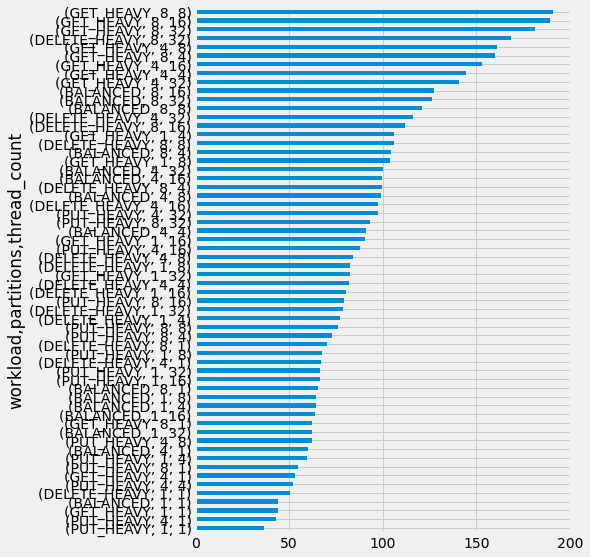

In [14]:
x = norm_succeeded.sort_values('sum', ascending=False)
display(x)
x['sum'].iloc[::-1].plot.barh(figsize=(6,9))

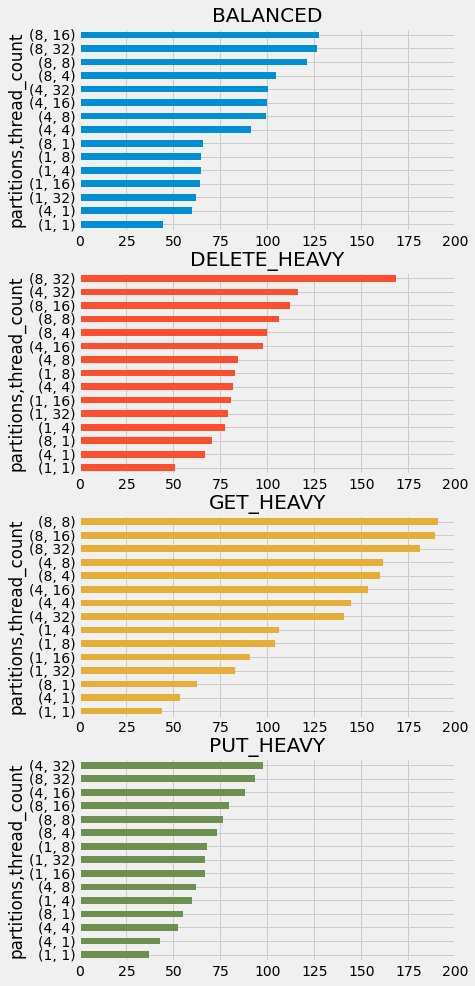

In [17]:
fig = plt.figure(figsize=(6, 16))
for i, (color, (workload, workload_df)) in enumerate(zip(colors, norm_succeeded.groupby('workload'))):
    ax = fig.add_subplot(4, 1, i+1)
    ax.set_title(workload)
    workload_df = workload_df.reset_index().set_index(['partitions', 'thread_count'])
    workload_df['sum'].sort_values(ascending=True).plot.barh(ax=ax, color=color)
    plt.xlim(0, 200)


status  final_file_size  duration_seconds        put         get     delete         sum
workload     partitions thread_count                                                                                            
PUT_HEAVY    4          16            succeeded       201.243634       3592.288282  79.141532    4.394929   4.397636   87.934097
             1          16            succeeded       182.286004       3591.315236  59.998261    3.334730   3.333392   66.666383
                        4             succeeded       181.752231       3591.233307  53.851751    2.991605   2.992281   59.835637
             8          16            succeeded       180.771670       3593.033580  71.646775    3.980528   3.979078   79.606381
             4          32            succeeded       174.374491       3592.219930  87.683225    4.870942   4.870806   97.424973
             8          32            succeeded       173.445852       3641.596027  84.214273    4.676247   4.677936   93.568455
                        8             succeeded       150.966478       3592.039180  68.647889    3.812281   3.811459   76.271629
             1          32            succeeded       147.527551       3590.704385  60.169646    3.342030   3.342252   66.853928
             4          8             succeeded       144.081010       3590.872307  55.987381    3.108143   3.109412   62.204937
             1          8             succeeded       128.430043       3591.272306  60.967810    3.387528   3.387881   67.743219
DELETE_HEAVY 1          32            succeeded       127.803302       3591.132620  35.508511    7.891966  35.512683   78.913159
PUT_HEAVY    8          4             succeeded       118.568020       3591.801291  65.724443    3.650343   3.651433   73.026219
DELETE_HEAVY 4          32            succeeded       109.188842       3591.343556  52.371170   11.638411  52.371156  116.380737
PUT_HEAVY    4          4             succeeded       106.786969       3591.236499  46.963280    2.608986   2.609474   52.181740
DELETE_HEAVY 1          8             succeeded       105.929045       3590.957497  37.270570    8.280731  37.272956   82.824257
             8          4             succeeded        96.367440       3592.587871  44.843063    9.964788  44.849700   99.657552
             1          4             succeeded        94.265181       3591.190748  34.836795    7.741864  34.836346   77.415004
BALANCED     8          8             succeeded        92.835070       3591.496975  40.022578   41.238154  40.021766  121.282498
DELETE_HEAVY 4          8             succeeded        91.658589       3592.242699  37.872614    8.415682  37.868228   84.156525
             8          32            succeeded        86.666685       3593.485939  75.834195   16.855194  75.840829  168.530218
                        8             succeeded        84.763388       3591.594894  47.794714   10.621528  47.792506  106.208749
PUT_HEAVY    4          1             succeeded        84.239681       3591.626139  38.720332    2.151660   2.150574   43.022566
             8          1             succeeded        83.574971       3591.498918  49.532956    2.752518   2.751787   55.037261
BALANCED     4          32            succeeded        83.271413       3591.101595  33.133399   34.132285  33.127089  100.392773
DELETE_HEAVY 4          16            succeeded        82.147529       3592.177134  43.862839    9.747152  43.856138   97.466129
GET_HEAVY    8          32            succeeded        76.962185       3590.609781  18.118432  153.996258   9.055363  181.170053
BALANCED     1          8             succeeded        75.323682       3590.630442  21.357678   22.002702  21.356433   64.716813
PUT_HEAVY    1          1             succeeded        74.939091       3591.010080  33.251394    1.847321   1.848149   36.946864
DELETE_HEAVY 8          16            succeeded        73.769790       3592.688346  50.459700   11.209115  50.455106  112.123921
BALANCED     4          16            succ

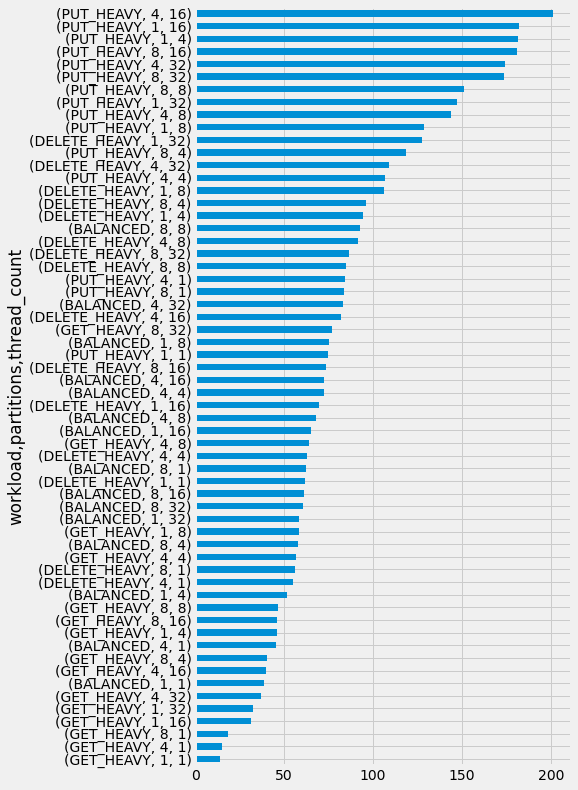

In [18]:
x = norm_succeeded.sort_values('final_file_size', ascending=False)
display(x)
x['final_file_size'].iloc[::-1].plot.barh(figsize=(6,13))

Text(0.5, 0.98, 'Relationship Between Performance and File Size Over Time')

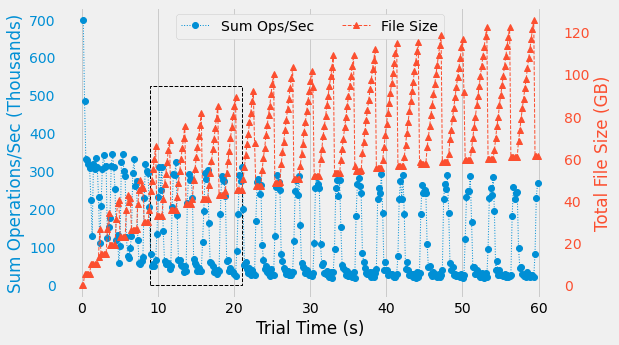

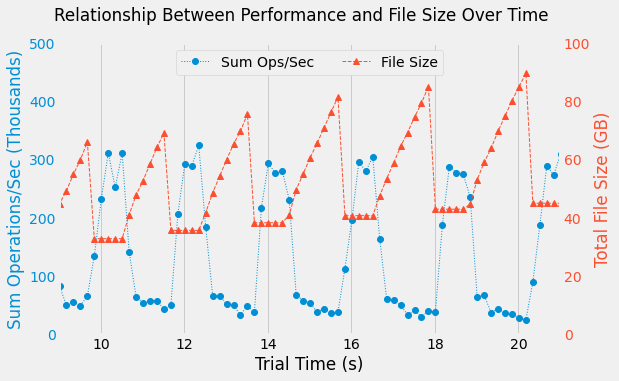

In [113]:
import matplotlib.patches as patches


x = grouped_results
x = x[x['workload'] == 'BALANCED']
x = x[x['partitions'] == 8]
x = x[x['thread_count'] == 16]
assert len(x) == 1
x = x.iloc[0]['results']
x = x.copy()

t = x['t'] / 60
ops_sec = (x[['put', 'get', 'delete']].sum(axis=1).iloc[1::].reset_index(drop=True) /
            diff(x['t']))
ops_sec /= 1000

#plt.figure(figsize=(8,5))
#plt.plot(t[1::], ops_sec)
#plt.xlabel('Trial Time (s)')
#plt.ylabel('Sum Operations/Sec (Thousands)')
#plt.axvline(9, color='k', lw=1, ls='--')
#plt.axvline(21, color='k', lw=1, ls='--')

def plot_ops_size():
    fig, ax1 = plt.subplots(figsize=(8,5))
    ax2 = ax1.twinx()

    l1, = ax1.plot(t[1::], ops_sec, color=colors[0], label='Sum Ops/Sec', marker='o', lw=1, ls=':')
    l2, = ax2.plot(t, x['file_size'] / 1e9, color=colors[1], label='File Size', marker='^', lw=1, ls='--')

    ax1.grid(False, axis='y')
    ax2.grid(False, axis='y')
    ax1.legend([l1, l2], [l1.get_label(), l2.get_label()],
               loc='upper center', ncol=2, framealpha=1)
    ax1.set_ylabel('Sum Operations/Sec (Thousands)', color=colors[0])
    ax1.tick_params(axis='y', colors=colors[0])
    ax2.set_ylabel('Total File Size (GB)', color=colors[1])
    ax2.tick_params(axis='y', colors=colors[1])
    ax1.set_xlabel('Trial Time (s)')
    return fig, ax1, ax2

fig, ax1, ax2 = plot_ops_size()
rect = patches.Rectangle((9,0),12,525, linewidth=1, edgecolor='k', facecolor='none', ls='--')
ax1.add_patch(rect)

fig, ax1, ax2 = plot_ops_size()

ax1.set_xlim(9, 21)
ax1.set_ylim(0, 500)
ax2.set_ylim(0, 100)
fig.suptitle('Relationship Between Performance and File Size Over Time', y=0.98)


In [108]:
 450 / 700 * 120

77.14285714285715